# Capstone Project - Battle of the Neighborhoods 
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction](#introduction)
* [Data](#data)
* [Analysis](#analysis)
* [Results](#results)
* [Conclusion](#conclusion)

## Introduction <a name="intrduction"></a>

#### Business Problem

I will be attempting to leverage data and analysis as well as some business knowledge to assist an entrepreneur in deciding a location for a new business. The chosen business is a **hookah bar** and the chosen city is **Austin, TX** 

I chose a **hookah bar** because it is exotic, multicultural, and in my experience, a good place for the youth in a large city to mingle. I chose **Austin** because it is a growing tech and education hub and would be a great city for a niche business like this to earn profit.

My selection and analysis of data will be aimed at segmenting the city and identifying  a location close to the **downtown/central business district** that is not yet saturated with hookah bars.

## Data <a name="data"></a>

Preliminary trial and error shows me that it will be most efficient to segment the city by zipcodes because the neighborhood set for Austin is so small that any conclusions made using those values will not be of great depth or accuracy. The zipcode set for this city is much larger and will provide a much clearer insight into the characteristics of the sections of the city and their viability for business.

Most of the data will be acquired using the **FoursquareAPI** and the **Google Maps API geocoding**

I found a simple lookup table at the **Opendatasoft** website that has US zipcodes tabulated with their latitude and longitude values. The site contains a convenient feature that lets users download tables for their desired geographical region.

#### Import necessary packages and install relevant modules

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import urllib
import requests
import numpy as np
import json
from pandas.io.json import json_normalize

In [2]:
import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

import folium

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values


print('Libraries imported.')

Libraries imported.


## Analysis <a name="analysis"></a>

#### Get zipcodes along with corresponding coordinates and clean up data

In [3]:
austin_zipcode_table=pd.read_csv('https://public.opendatasoft.com/explore/dataset/us-zip-code-latitude-and-longitude/download/?format=csv&refine.state=TX&timezone=America/Denver', sep=';')
austin_zipcode_table=austin_zipcode_table.drop(['timezone', 'dst', 'geopoint'], axis=1)


#### There are 83 zipcodes in total

In [4]:
austin_data=austin_zipcode_table[austin_zipcode_table['city']=='Austin'].reset_index(drop=True)
austin_data.rename({'zip': 'Zipcode'}, axis=1, inplace=True)
austin_data = austin_data.drop(['city', 'state'], axis=1).reset_index(drop=True)
print(austin_data.shape)


print(austin_data.count())
austin_data.head()

(83, 3)
Zipcode      83
latitude     83
longitude    83
dtype: int64


Zipcode   latitude  longitude
0    78749  30.216108 -97.858280
1    78785  30.326374 -97.771258
2    78735  30.250761 -97.844690
3    78761  30.326374 -97.771258
4    78972  30.315360 -97.663293

In [5]:
url_borders = 'http://polygons.openstreetmap.fr/get_geojson.py?id=113314&parama=0'
austin_borders  = requests.get(url_borders).json()

address = 'Austin, Texas'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Austin are {}, {}.'.format(latitude, longitude))

C:\Users\owner\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: Using Nominatim with the default "geopy/1.20.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  


The geograpical coordinate of Austin are 30.2711286, -97.7436995.


#### Overlay zipcode locations unto map of Austin

In [6]:
map_austin = folium.Map(location=[latitude, longitude], zoom_start=10, tiles = "OpenStreetMap")

# add markers to map
for lat, lng, zipcode in zip(austin_data['latitude'], austin_data['longitude'], austin_data['Zipcode']):
    label = '{},'.format(zipcode)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_austin)  
    
map_austin.choropleth(geo_data = austin_borders, fill_color=None)

map_austin

In [7]:
{
    "tags": [
        "remove_input",
    ]
}

CLIENT_ID = 'UISM5KU1JZVMGVGO3MDL1X3XAKO1VMNB4EEQMYVH4CHNMJKT'
CLIENT_SECRET = 'ULT5ZGDXE2YDQIJKO1UT54IWGYGPWLXNBH1I2DL5A1EHYNAN'
VERSION = '20180605' # Foursquare API version

print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentials:
CLIENT_ID: UISM5KU1JZVMGVGO3MDL1X3XAKO1VMNB4EEQMYVH4CHNMJKT
CLIENT_SECRET:ULT5ZGDXE2YDQIJKO1UT54IWGYGPWLXNBH1I2DL5A1EHYNAN


#### Locate ideal zipcode as the current most successful zipcode in the hookah business in Austin

In [8]:
query = 'hookah'
radius = 50000
LIMIT = 40
    
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(
    CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, query, radius, LIMIT)
url

'https://api.foursquare.com/v2/venues/search?client_id=UISM5KU1JZVMGVGO3MDL1X3XAKO1VMNB4EEQMYVH4CHNMJKT&client_secret=ULT5ZGDXE2YDQIJKO1UT54IWGYGPWLXNBH1I2DL5A1EHYNAN&ll=30.2711286,-97.7436995&v=20180605&query=hookah&radius=50000&limit=40'

In [9]:
results = requests.get(url).json()
venues = results['response']['venues']
df = json_normalize(venues)
df.head()

categories  hasPerk  \
0  [{'id': '4bf58dd8d48988d119941735', 'name': 'H...    False   
1  [{'id': '4bf58dd8d48988d119941735', 'name': 'H...    False   
2  [{'id': '4bf58dd8d48988d119941735', 'name': 'H...    False   
3  [{'id': '4d4b7105d754a06374d81259', 'name': 'F...    False   
4  [{'id': '4bf58dd8d48988d119941735', 'name': 'H...    False   

                         id     location.address location.cc location.city  \
0  4de1d0a0c65b7a3e210cb339  2621 Jones Rd Ste A          US        Austin   
1  5515eda7498ed8db3d8eccdd   84 N Interstate 35          US        Austin   
2  52e9cbb411d224511aab8d1b    2001 Guadalupe St          US        Austin   
3  4f321e0f19836c91c7b7abad        104 E 31st St          US        Austin   
4  53097b9d11d22bc58e3e8c01                  NaN          US        Austin   

  location.country location.crossStreet  location.distance  \
0    United States                  NaN               7705   
1    United States                  NaN               1396   
2    United States          West campus               1342   
3    United States                  NaN               2756   
4    United States                  NaN               3773   

                           location.formattedAddress  \
0  [2621 Jones Rd Ste A, Austin, TX 78745, United...   
1  [84 N Interstate 35, Austin, TX 78701, United ...   
2  [2001 Guadalupe St (West campus), Austin, TX 7...   
3   [104 E 31st St, Austin, TX 78705, United States]   
4                        [Austin, TX, United States]   

                             location.labeledLatLngs  location.lat  \
0  [{'label': 'display', 'lat': 30.22476737406097...     30.224767   
1  [{'label': 'display', 'lat': 30.25970602164228...     30.259706   
2  [{'label': 'display', 'lat': 30.28308358432630...     30.283084   
3  [{'label': 'display', 'lat': 30.29515, 'lng': ...     30.295150   
4  [{'label': 'display', 'lat': 30.23995845483286...     30.239958   

   location.lng location.postalCode location.state  \
0    -97.803196               78745             TX   
1    -97.737685               78701             TX   
2    -97.741885               78705             TX   
3    -97.736730               78705             TX   
4    -97.728274                 NaN             TX   

                                   name    referralId venuePage.id  
0  Off The Hookah Lounge And Smoke Shop  v-1561804750          NaN  
1            Rainey Hookah Lounge & Bar  v-1561804750          NaN  
2                        Babylon Hookah  v-1561804750          NaN  
3              Smoke 'N O's Hookah Cafe  v-1561804750          NaN  
4                 Ontario Hookah Lounge  v-1561804750          NaN

In [10]:
df = df[['name', 'location.postalCode', 'location.city']]
df = df[df['location.city'] == 'Austin']
df.rename({'location.city':'City', 'location.postalCode':'Zipcode'}, axis=1, inplace=True)
df = df.dropna(subset=['Zipcode'], how='any', axis=0).reset_index(drop=True)
print(df.shape)
df

(13, 3)


name Zipcode    City
0   Off The Hookah Lounge And Smoke Shop   78745  Austin
1             Rainey Hookah Lounge & Bar   78701  Austin
2                         Babylon Hookah   78705  Austin
3               Smoke 'N O's Hookah Cafe   78705  Austin
4                 Kasbah Moroccan Lounge   78705  Austin
5                            Hookah Buzz   78759  Austin
6                       Royal Hookah Bar   78722  Austin
7                     Rawshe Hookah Cafe   78753  Austin
8                   Yahala Hookah Lounge   78752  Austin
9          The Bulgarian's Hookah Lounge   78748  Austin
10                     Lone Star Hookahs   78705  Austin
11         Gossip Social Lounge (Hookah)   78753  Austin
12                 Moonlight Hookah Cafe   78759  Austin

In [11]:
df_rankedby_bars = df.groupby('Zipcode').count()
df_rankedby_bars = df_rankedby_bars.drop(['City'], axis=1)
df_rankedby_bars.sort_values(['name'], ascending=False, axis=0, inplace=True)
print(df_rankedby_bars.sum())

indicator_zipcode = df_rankedby_bars['name'].argmax()
print ('\033[7m' + indicator_zipcode)
df_rankedby_bars

name    13
dtype: int64
78705


C:\Users\owner\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  


name
Zipcode      
78705       4
78753       2
78759       2
78701       1
78722       1
78745       1
78748       1
78752       1

#### Ideal zipcode to emulate identified as:       78705, having the most hookah bars in the city

In [12]:
{
    "tags": [
        "hide_input",
    ]
}

ax=df_rankedby_bars.plot(kind='bar', figsize=(18,8), width=0.2, fontsize=14, color='#006400')

ax.set_title('Number of Hookah Bars in each Zipcode', fontsize=25)
ax.set_yticks([])
ax.legend().remove()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(True)

totals = []

# find the values and append to list
for i in ax.patches:
    totals.append(i.get_height())


# set individual bar lables using above list
for i in ax.patches:
    # get_x pulls left or right;
    ax.text(i.get_x()-.02, i.get_height()+.15, \
            str(round((i.get_height()), 2)), fontsize=14)


#### Get list of businesses in all zipcodes, up to a treshold, for cluster analysis

In [13]:
LIMIT = 100
radius = 500

def getNearbyVenues(names, latitudes, longitudes):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Zipcode', 
                  'Zipcode Latitude', 
                  'Zipcode Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


austin_venues = getNearbyVenues(names=austin_data['Zipcode'],
                                   latitudes=austin_data['latitude'],
                                   longitudes=austin_data['longitude']
                                  )

austin_venues.head()

78749
78785
78735
78761
78972
78730
78779
78746
78725
78772
78739
78734
78768
78716
78721
78787
78750
78788
78710
78751
78752
78754
78712
78723
78733
78708
78705
78701
78729
73301
78748
78738
78720
78704
78763
78715
78762
78727
78714
78722
78771
78781
78780
78717
78703
78744
78759
78783
78745
78774
78758
78724
78764
78741
78767
78731
78769
78747
78756
78736
78765
78773
78789
78709
78766
78719
78711
78726
78760
78782
78718
73344
78753
78702
78742
78786
78728
78732
78737
78713
78757
78778
78755


Zipcode  Zipcode Latitude  Zipcode Longitude                      Venue  \
0    78749         30.216108         -97.858280  Brookdale Beckett Meadows   
1    78749         30.216108         -97.858280                 BA Rentals   
2    78749         30.216108         -97.858280  Pool at Dick Nichols Park   
3    78785         30.326374         -97.771258   Ridge Oak Reservoir Park   
4    78785         30.326374         -97.771258                Oates Oasis   

   Venue Latitude  Venue Longitude              Venue Category  
0       30.217932       -97.860660             Assisted Living  
1       30.218750       -97.861610  Construction & Landscaping  
2       30.213670       -97.862301                        Pool  
3       30.330140       -97.770240                        Park  
4       30.322485       -97.773685                        Lake

#### Prepare data for K-means clustering based on business characteristics (The aim is to identify which cluster our ideal zipcode from earlier lands in):   78705

In [14]:
austin_venues.groupby('Zipcode').count()

# one hot encoding
austin_onehot = pd.get_dummies(austin_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
austin_onehot['Zipcode'] = austin_venues['Zipcode'] 

# move neighborhood column to the first column
fixed_columns = [austin_onehot.columns[-1]] + list(austin_onehot.columns[:-1])
austin_onehot = austin_onehot[fixed_columns]

austin_onehot.head()

Zipcode  Accessories Store  American Restaurant  Arcade  Art Gallery  \
0    78749                  0                    0       0            0   
1    78749                  0                    0       0            0   
2    78749                  0                    0       0            0   
3    78785                  0                    0       0            0   
4    78785                  0                    0       0            0   

   Art Museum  Arts & Crafts Store  Asian Restaurant  Assisted Living  \
0           0                    0                 0                1   
1           0                    0                 0                0   
2           0                    0                 0                0   
3           0                    0                 0                0   
4           0                    0                 0                0   

   Athletics & Sports  Auto Workshop  BBQ Joint  Bagel Shop  Bakery  Bank  \
0                   0              0          0           0       0     0   
1                   0              0          0           0       0     0   
2                   0              0          0           0       0     0   
3                   0              0          0           0       0     0   
4                   0              0          0           0       0     0   

   Bar  Basketball Court  Bed & Breakfast  Beer Garden  Beer Store  Boutique  \
0    0                 0                0            0           0         0   
1    0                 0                0            0           0         0   
2    0                 0                0            0           0         0   
3    0                 0                0            0           0         0   
4    0                 0                0            0           0         0   

   Breakfast Spot  Burger Joint  Bus Line  Bus Stop  Business Service  \
0               0             0         0         0                 0   
1               0             0         0         0                 0   
2               0             0         0         0                 0   
3               0             0         0         0                 0   
4               0             0         0         0                 0   

   Butcher  Cafeteria  Café  Cajun / Creole Restaurant  Capitol Building  \
0        0          0     0                          0                 0   
1        0          0     0                          0                 0   
2        0          0     0                          0                 0   
3        0          0     0                          0                 0   
4        0          0     0                          0                 0   

   Casino  Chinese Restaurant  Clothing Store  Cocktail Bar  Coffee Shop  \
0       0                   0               0             0            0   
1       0                   0               0             0            0   
2       0                   0               0             0            0   
3       0                   0               0             0            0   
4       0                   0               0             0            0   

   College Arts Building  College Gym  College Quad  Comedy Club  \
0                      0            0             0            0   
1                      0            0             0            0   
2                      0            0             0            0   
3                      0            0             0            0   
4                      0            0             0            0   

   Concert Hall  Construction & Landscaping  Convenience Store  \
0             0                           0                  0   
1             0                           1                  0   
2             0                           0                  0   
3             0                           0                  0   
4             0                           0                  0   

   Cosmeti

In [15]:
austin_grouped = austin_onehot.groupby('Zipcode').mean().reset_index()
austin_grouped.head()

Zipcode  Accessories Store  American Restaurant  Arcade  Art Gallery  \
0    73301           0.000000                  0.0     0.0     0.000000   
1    73344           0.000000                  0.0     0.0     0.000000   
2    78701           0.012821                  0.0     0.0     0.000000   
3    78702           0.000000                  0.0     0.0     0.000000   
4    78703           0.000000                  0.0     0.0     0.166667   

   Art Museum  Arts & Crafts Store  Asian Restaurant  Assisted Living  \
0    0.000000                  0.0               0.0              0.0   
1    0.000000                  0.0               0.0              0.0   
2    0.012821                  0.0               0.0              0.0   
3    0.000000                  0.0               0.0              0.0   
4    0.000000                  0.0               0.0              0.0   

   Athletics & Sports  Auto Workshop  BBQ Joint  Bagel Shop  Bakery      Bank  \
0                 0.0            0.0        0.0    0.000000     0.0  0.000000   
1                 0.0            0.0        0.0    0.000000     0.0  0.000000   
2                 0.0            0.0        0.0    0.012821     0.0  0.000000   
3                 0.0            0.0        0.0    0.000000     0.0  0.038462   
4                 0.0            0.0        0.0    0.000000     0.0  0.000000   

        Bar  Basketball Court  Bed & Breakfast  Beer Garden  Beer Store  \
0  0.000000               0.0              0.0          0.0         0.0   
1  0.000000               0.0              0.0          0.0         0.0   
2  0.064103               0.0              0.0          0.0         0.0   
3  0.038462               0.0              0.0          0.0         0.0   
4  0.000000               0.0              0.0          0.0         0.0   

   Boutique  Breakfast Spot  Burger Joint  Bus Line  Bus Stop  \
0       0.0        0.000000      0.000000  0.000000       0.0   
1       0.0        0.000000      0.000000  0.000000       0.0   
2       0.0        0.012821      0.025641  0.012821       0.0   
3       0.0        0.038462      0.000000  0.000000       0.0   
4       0.0        0.000000      0.000000  0.000000       0.0   

   Business Service   Butcher  Cafeteria      Café  Cajun / Creole Restaurant  \
0               0.0  0.000000   0.000000  0.000000                        0.0   
1               0.0  0.000000   0.000000  0.000000                        0.0   
2               0.0  0.000000   0.012821  0.012821                        0.0   
3               0.0  0.038462   0.000000  0.000000                        0.0   
4               0.0  0.000000   0.000000  0.000000                        0.0   

   Capitol Building  Casino  Chinese Restaurant  Clothing Store  Cocktail Bar  \
0          0.000000     0.0                 0.0             0.0      0.000000   
1          0.000000     0.0                 0.0             0.0      0.000000   
2          0.025641     0.0                 0.0             0.0      0.051282   
3          0.000000     0.0                 0.0             0.0      0.076923   
4          0.000000     0.0                 0.0             0.0      0.000000   

   Coffee Shop  College Arts Building  College Gym  College Quad  Comedy Club  \
0     0.000000                    0.0          0.0           0.0     0.000000   
1     0.000000                    0.0          0.0           0.0     0.000000   
2     0.038462                    0.0          0.0           0.0     0.025641   
3     0.153846                    0.0          0.0           0.0     0.000000   
4     0.000000                    0.0          0.0           0.0     0.000000   

   Concert Hall  Construction & Landscaping  Convenience Store  \
0           0.0                         0.0           0.000000   
1           0.0                         0.0           0.000000   
2           0.0                         0.0           0.000000   
3           0.0                         0.0           0.076

In [16]:
num_top_venues = 5

for hood in austin_grouped['Zipcode']:
    temp = austin_grouped[austin_grouped['Zipcode'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')


              venue  freq
0              Park   0.5
1              Lake   0.5
2      Optical Shop   0.0
3  Motorsports Shop   0.0
4     Movie Theater   0.0


              venue  freq
0              Park   0.5
1              Lake   0.5
2      Optical Shop   0.0
3  Motorsports Shop   0.0
4     Movie Theater   0.0


            venue  freq
0           Hotel  0.09
1             Bar  0.06
2  Sandwich Place  0.05
3    Cocktail Bar  0.05
4     Coffee Shop  0.04


                  venue  freq
0           Coffee Shop  0.15
1    Mexican Restaurant  0.12
2  Fast Food Restaurant  0.08
3     Convenience Store  0.08
4          Cocktail Bar  0.08


                 venue  freq
0                 Pool  0.17
1                 Park  0.17
2    Mobile Phone Shop  0.17
3                Trail  0.17
4  Sporting Goods Shop  0.17


                venue  freq
0  Mexican Restaurant  0.08
1         Coffee Shop  0.08
2              Bakery  0.08
3                Park  0.04
4          Soup Place  0.04


          

              venue  freq
0              Park   0.5
1              Lake   0.5
2      Optical Shop   0.0
3  Motorsports Shop   0.0
4     Movie Theater   0.0


               venue  freq
0     Discount Store   0.4
1        Video Store   0.2
2       Liquor Store   0.2
3                Bar   0.2
4  Accessories Store   0.0


                venue  freq
0         Gas Station  0.33
1   Convenience Store  0.33
2  Chinese Restaurant  0.33
3   Accessories Store  0.00
4        Optical Shop  0.00


              venue  freq
0              Park   0.5
1              Lake   0.5
2      Optical Shop   0.0
3  Motorsports Shop   0.0
4     Movie Theater   0.0


                venue  freq
0                 Bar  0.18
1         Coffee Shop  0.12
2  Mexican Restaurant  0.12
3      Cosmetics Shop  0.06
4          Taco Place  0.06


               venue  freq
0     Scenic Lookout   0.5
1       Home Service   0.5
2  Accessories Store   0.0
3    Motorcycle Shop   0.0
4   Motorsports Shop   0.0


              ve

In [17]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 15

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Zipcode']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
zipcodes_venues_sorted = pd.DataFrame(columns=columns)
zipcodes_venues_sorted['Zipcode'] = austin_grouped['Zipcode']

for ind in np.arange(austin_grouped.shape[0]):
    zipcodes_venues_sorted.iloc[ind, 1:] = return_most_common_venues(austin_grouped.iloc[ind, :], num_top_venues)

zipcodes_venues_sorted.head()

Zipcode 1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0    73301                  Lake                  Park           Yoga Studio   
1    73344                  Lake                  Park           Yoga Studio   
2    78701                 Hotel                   Bar          Cocktail Bar   
3    78702           Coffee Shop    Mexican Restaurant     Convenience Store   
4    78703                  Pool                 Trail                  Park   

  4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
0     Electronics Store            Food Truck     Food & Drink Shop   
1     Electronics Store            Food Truck     Food & Drink Shop   
2        Sandwich Place           Music Venue         Movie Theater   
3  Fast Food Restaurant                   Pub          Cocktail Bar   
4     Mobile Phone Shop   Sporting Goods Shop           Art Gallery   

  7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
0                  Food           Flower Shop  Fast Food Restaurant   
1                  Food           Flower Shop  Fast Food Restaurant   
2           Coffee Shop            Steakhouse    Italian Restaurant   
3                  Bank             Gift Shop               Butcher   
4     Health Food Store            Donut Shop           Flower Shop   

  10th Most Common Venue 11th Most Common Venue 12th Most Common Venue  \
0                   Farm            Fabric Shop            Dry Cleaner   
1                   Farm            Fabric Shop            Dry Cleaner   
2       Capitol Building           Burger Joint            Comedy Club   
3         Sandwich Place         Breakfast Spot                    Bar   
4          Historic Site   Fast Food Restaurant                   Farm   

  13th Most Common Venue 14th Most Common Venue 15th Most Common Venue  
0               Fountain             Donut Shop                Dog Run  
1               Fountain             Donut Shop                Dog Run  
2                 Lounge     Mexican Restaurant         Breakfast Spot  
3             Taco Place             Food Truck     Italian Restaurant  
4            Fabric Shop      Electronics Store            Dry Cleaner

#### All zipcodes have been appended with their 15 most popular business venues as their identifying characteristic

#### K-means clustering can now be used to segment them

In [18]:
# set number of clusters
kclusters = 8

austin_grouped_clustering = austin_grouped.drop('Zipcode', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(austin_grouped_clustering)

zipcodes_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

austin_merged = austin_data

# merge austin_grouped with austin_data to add latitude/longitude for each neighborhood
austin_merged = austin_merged.join(zipcodes_venues_sorted.set_index('Zipcode'), on='Zipcode')

austin_merged=austin_merged.fillna(0)

austin_merged




Zipcode   latitude  longitude  Cluster Labels   1st Most Common Venue  \
0     78749  30.216108 -97.858280             4.0                    Pool   
1     78785  30.326374 -97.771258             1.0                    Lake   
2     78735  30.250761 -97.844690             4.0                   Hotel   
3     78761  30.326374 -97.771258             1.0                    Lake   
4     78972  30.315360 -97.663293             4.0            Liquor Store   
5     78730  30.359935 -97.831250             0.0                       0   
6     78779  30.326374 -97.771258             1.0                    Lake   
7     78746  30.287739 -97.802200             0.0                       0   
8     78725  30.231583 -97.609920             0.0                       0   
9     78772  30.326374 -97.771258             1.0                    Lake   
10    78739  30.172070 -97.872840             0.0                       0   
11    78734  30.378675 -97.950280             4.0                   Hotel   
12    78768  30.326374 -97.771258             1.0                    Lake   
13    78716  30.316223 -97.858770             4.0               BBQ Joint   
14    78721  30.272926 -97.686650             4.0            Dessert Shop   
15    78787  30.326374 -97.771258             1.0                    Lake   
16    78750  30.438933 -97.803830             3.0            Tennis Court   
17    78788  30.326374 -97.771258             1.0                    Lake   
18    78710  30.351953 -97.715123             4.0      Mexican Restaurant   
19    78751  30.310707 -97.723000             4.0                Bus Stop   
20    78752  30.332506 -97.705710             4.0                   Hotel   
21    78754  30.354234 -97.646790             0.0                       0   
22    78712  30.285207 -97.735394             4.0             Coffee Shop   
23    78723  30.306507 -97.686510             0.0     Fried Chicken Joint   
24    78733  30.329704 -97.875100             2.0            Concert Hall   
25    78708  30.326374 -97.771258             1.0                    Lake   
26    78705  30.292424 -97.738560             4.0            Burger Joint   
27    78701  30.271270 -97.741030             4.0                   Hotel   
28    78729  30.451348 -97.765880             0.0         Motorcycle Shop   
29    73301  30.326374 -97.771258             1.0                    Lake   
30    78748  30.172020 -97.822650             4.0             Pizza Place   
31    78738  30.340111 -97.988690             6.0             Golf Course   
32    78720  30.326374 -97.771258             1.0                    Lake   
33    78704  30.246309 -97.760870             4.0             Coffee Shop   
34    78763  30.335398 -97.559807             4.0          Discount Store   
35    78715  30.450088 -97.486509             0.0                       0   
36    78762  30.326374 -97.771258             1.0                    Lake   
37    78727  30.425652 -97.714190             4.0                  Bakery   
38    78714  30.335787 -97.443751             0.0                       0   
39    78722  30.289307 -97.716590             4.0                 Theater   
40    78771  30.326374 -97.771258             1.0                    Lake   
41    78781  30.326374 -97.771258             1.0                    Lake   
42    78780  30.326374 -97.771258             1.0                    Lake   
43    78717  30.494623 -97.756870             0.0                       0   
44    78703  30.290907 -97.762770             4.0                    Pool   
45    78744  30.188377 -97.740380             4.0        Recording Studio   
46    78759  30.406169 -97.757430             5.0                    Park   
47    78783  30.326374 -97.771258             1.0                    Lake   
48    78745  30.207559 -97.795750             4.0                   Hotel   
49    78774  30.326374 -97.771258             1.0                    Lake   
50    78758  30.384204 -97.703920             0.0                       0   


#### The random distribution of the similarly-colored dots shows that the clusters were actually chosen by shared characteristics, rather than location

In [19]:
{
    "tags": [
        "hide_input",
    ]
}

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]



# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(austin_merged['latitude'], austin_merged['longitude'], austin_merged['Zipcode'], austin_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters.choropleth(geo_data = austin_borders, fill_color='transparent')

map_clusters

#### Clusters are tabulated below and we will extract the cluster that contains our ideal zipcode

In [20]:
austin_merged.loc[austin_merged['Cluster Labels'] == 1, austin_merged.columns[[0] + list(range(5, austin_merged.shape[1]))]]

Zipcode 2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
1     78785                  Park           Yoga Studio     Electronics Store   
3     78761                  Park           Yoga Studio     Electronics Store   
6     78779                  Park           Yoga Studio     Electronics Store   
9     78772                  Park           Yoga Studio     Electronics Store   
12    78768                  Park           Yoga Studio     Electronics Store   
15    78787                  Park           Yoga Studio     Electronics Store   
17    78788                  Park           Yoga Studio     Electronics Store   
25    78708                  Park           Yoga Studio     Electronics Store   
29    73301                  Park           Yoga Studio     Electronics Store   
32    78720                  Park           Yoga Studio     Electronics Store   
36    78762                  Park           Yoga Studio     Electronics Store   
40    78771                  Park           Yoga Studio     Electronics Store   
41    78781                  Park           Yoga Studio     Electronics Store   
42    78780                  Park           Yoga Studio     Electronics Store   
47    78783                  Park           Yoga Studio     Electronics Store   
49    78774                  Park           Yoga Studio     Electronics Store   
56    78769                  Park           Yoga Studio     Electronics Store   
60    78765                  Park           Yoga Studio     Electronics Store   
61    78773                  Park           Yoga Studio     Electronics Store   
62    78789                  Park           Yoga Studio     Electronics Store   
63    78709                  Park           Yoga Studio     Electronics Store   
66    78711                  Park           Yoga Studio     Electronics Store   
68    78760                  Park           Yoga Studio     Electronics Store   
69    78782                  Park           Yoga Studio     Electronics Store   
70    78718                  Park           Yoga Studio     Electronics Store   
71    73344                  Park           Yoga Studio     Electronics Store   
75    78786                  Park           Yoga Studio     Electronics Store   
81    78778                  Park           Yoga Studio     Electronics Store   
82    78755                  Park           Yoga Studio     Electronics Store   

   5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
1             Food Truck     Food & Drink Shop                  Food   
3             Food Truck     Food & Drink Shop                  Food   
6             Food Truck     Food & Drink Shop                  Food   
9             Food Truck     Food & Drink Shop                  Food   
12            Food Truck     Food & Drink Shop                  Food   
15            Food Truck     Food & Drink Shop                  Food   
17            Food Truck     Food & Drink Shop                  Food   
25            Food Truck     Food & Drink Shop                  Food   
29            Food Truck     Food & Drink Shop                  Food   
32            Food Truck     Food & Drink Shop                  Food   
36            Food Truck     Food & Drink Shop                  Food   
40            Food Truck     Food & Drink Shop                  Food   
41            Food Truck     Food & Drink Shop                  Food   
42            Food Truck     Food & Drink Shop                  Food   
47            Food Truck     Food & Drink Shop                  Food   
49            Food Truck     Food & Drink Shop                  Food   
56            Food Truck     Food & Drink Shop                  Food   
60            Food Truck     Food & Drink Shop                  Food   
61            Food Truck     Food & Drink Shop                  Food   
62            Food Truck     Food & Drink Shop                  Food   
63            Food Truck     Food & Drink Shop               

In [21]:
austin_merged.loc[austin_merged['Cluster Labels'] == 2, austin_merged.columns[[0] + list(range(5, austin_merged.shape[1]))]]

Zipcode 2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
24    78733           Yoga Studio           Dry Cleaner            Food Truck   
79    78713      Football Stadium           Dry Cleaner            Food Truck   

   5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
24     Food & Drink Shop                  Food           Flower Shop   
79     Food & Drink Shop                  Food           Flower Shop   

   8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  \
24  Fast Food Restaurant                  Farm            Fabric Shop   
79  Fast Food Restaurant                  Farm            Fabric Shop   

   11th Most Common Venue 12th Most Common Venue 13th Most Common Venue  \
24      Electronics Store             Donut Shop               Fountain   
79      Electronics Store            Yoga Studio               Fountain   

   14th Most Common Venue 15th Most Common Venue  
24                Dog Run        Doctor's Office  
79                Dog Run        Doctor's Office

In [22]:
austin_merged.loc[austin_merged['Cluster Labels'] == 3, austin_merged.columns[[0] + list(range(5, austin_merged.shape[1]))]]

Zipcode 2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
16    78750           Yoga Studio     French Restaurant      Football Stadium   

   5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
16            Food Truck     Food & Drink Shop                  Food   

   8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  \
16           Flower Shop  Fast Food Restaurant                   Farm   

   11th Most Common Venue 12th Most Common Venue 13th Most Common Venue  \
16            Fabric Shop      Electronics Store            Dry Cleaner   

   14th Most Common Venue 15th Most Common Venue  
16             Donut Shop                Dog Run

In [23]:
ideal_cluster=austin_merged.loc[austin_merged['Cluster Labels'] == 4, austin_merged.columns[[0] + list(range(5, austin_merged.shape[1]))]]
ideal_cluster

Zipcode       2nd Most Common Venue       3rd Most Common Venue  \
0     78749  Construction & Landscaping             Assisted Living   
2     78735                         Gym                  Playground   
4     78972          Athletics & Sports            Department Store   
11    78734                 Video Store                    Ski Shop   
13    78716                 Pizza Place                   Pet Store   
14    78721                 Art Gallery                        Park   
18    78710           Korean Restaurant                  Hobby Shop   
19    78751                        Pool                 Coffee Shop   
20    78752           Indian Restaurant               Movie Theater   
22    78712                        Pool        Fast Food Restaurant   
26    78705                  Food Truck           Convenience Store   
27    78701                         Bar                Cocktail Bar   
30    78748        Gym / Fitness Center        Fast Food Restaurant   
33    78704          Mexican Restaurant                      Bakery   
34    78763                Liquor Store                 Video Store   
37    78727         Sporting Goods Shop                 Dry Cleaner   
39    78722                Intersection                 Music Venue   
44    78703                       Trail                        Park   
45    78744           Recreation Center         Fried Chicken Joint   
48    78745                      Bakery  Construction & Landscaping   
51    78724          Mexican Restaurant                      Market   
52    78764                 Gas Station          Chinese Restaurant   
53    78741                    Bus Stop                       Trail   
54    78767              Scenic Lookout                 Yoga Studio   
55    78731          Mexican Restaurant                 Gas Station   
58    78756                 Yoga Studio          Mexican Restaurant   
59    78736               Souvenir Shop                 Yoga Studio   
64    78766                 Coffee Shop          Mexican Restaurant   
67    78726      Furniture / Home Store                         Gym   
72    78753                  Food Truck              Sandwich Place   
73    78702          Mexican Restaurant           Convenience Store   
76    78728                        Pool                        Lake   
78    78737            Business Service                 Yoga Studio   
80    78757                      Bakery                Burger Joint   

    4th Most Common Venue   5th Most Common Venue      6th Most Common Venue  \
0       Electronics Store        Football Stadium                 Food Truck   
2                 Dog Run       Electronics Store                       Farm   
4          Discount Store      Chinese Restaurant       Fast Food Restaurant   
11           Intersection       Electronics Store                 Food Truck   
13            Dry Cleaner              Food Truck          Food & Drink Shop   
14            Yoga Studio             Fabric Shop           Football Stadium   
18   Gym / Fitness Center             Comedy Club             Shipping Store   
19     Mexican Restaurant          Breakfast Spot                 Beer Store   
20       Sushi Restaurant       Korean Restaurant         Chinese Restaurant   
22  Performing Arts Venue        Football Stadium               College Quad   
26            Music Venue              Taco Place             Sandwich Place   
27         Sandwich Place             Music Venue              Movie Theater   
30            Video Store             Beer Garden                   Pharmacy   
33      Health Food Store              Taco Place               Optical Shop   
34                    Bar             Yoga Studio                Fabric Shop   
37       Sushi Restaurant                    Bank            Motorcycle Shop   
39            Coffee Shop                    Park                 Food Truck   
44      Mobile Phone Shop     Sporting Goods Shop                Art Gallery  

In [24]:
austin_merged.loc[austin_merged['Cluster Labels'] == 5, austin_merged.columns[[0] + list(range(5, austin_merged.shape[1]))]]

Zipcode 2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
46    78759           Yoga Studio           Dry Cleaner            Food Truck   
77    78732           Yoga Studio           Dry Cleaner            Food Truck   

   5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
46     Food & Drink Shop                  Food           Flower Shop   
77     Food & Drink Shop                  Food           Flower Shop   

   8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  \
46  Fast Food Restaurant                  Farm            Fabric Shop   
77  Fast Food Restaurant                  Farm            Fabric Shop   

   11th Most Common Venue 12th Most Common Venue 13th Most Common Venue  \
46      Electronics Store             Donut Shop               Fountain   
77      Electronics Store             Donut Shop               Fountain   

   14th Most Common Venue 15th Most Common Venue  
46                Dog Run        Doctor's Office  
77                Dog Run        Doctor's Office

In [25]:
austin_merged.loc[austin_merged['Cluster Labels'] == 6, austin_merged.columns[[0] + list(range(5, austin_merged.shape[1]))]]

Zipcode 2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
31    78738           Yoga Studio     Electronics Store            Food Truck   

   5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
31     Food & Drink Shop                  Food           Flower Shop   

   8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  \
31  Fast Food Restaurant                  Farm            Fabric Shop   

   11th Most Common Venue 12th Most Common Venue 13th Most Common Venue  \
31            Dry Cleaner               Fountain             Donut Shop   

   14th Most Common Venue 15th Most Common Venue  
31                Dog Run        Doctor's Office

In [26]:
austin_merged.loc[austin_merged['Cluster Labels'] == 7, austin_merged.columns[[0] + list(range(5, austin_merged.shape[1]))]]

Zipcode 2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
74    78742           Yoga Studio           Dry Cleaner            Food Truck   

   5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
74     Food & Drink Shop                  Food           Flower Shop   

   8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  \
74  Fast Food Restaurant                  Farm            Fabric Shop   

   11th Most Common Venue 12th Most Common Venue 13th Most Common Venue  \
74      Electronics Store             Donut Shop               Fountain   

   14th Most Common Venue 15th Most Common Venue  
74                Dog Run        Doctor's Office

In [27]:
austin_merged.loc[austin_merged['Cluster Labels'] == 8, austin_merged.columns[[0] + list(range(5, austin_merged.shape[1]))]]

Empty DataFrame
Columns: [Zipcode, 2nd Most Common Venue, 3rd Most Common Venue, 4th Most Common Venue, 5th Most Common Venue, 6th Most Common Venue, 7th Most Common Venue, 8th Most Common Venue, 9th Most Common Venue, 10th Most Common Venue, 11th Most Common Venue, 12th Most Common Venue, 13th Most Common Venue, 14th Most Common Venue, 15th Most Common Venue]
Index: []

#### Rapid parsing shows that the ideal zipcode (78705) lands in Cluster4, making it the ideal cluster

In [36]:
ideal_cluster_zipcodes=ideal_cluster['Zipcode'].reset_index()
ideal_cluster_data = pd.merge(ideal_cluster_zipcodes, austin_data, on='Zipcode').drop('index', axis=1).reset_index()
print(ideal_cluster_data.shape)
ideal_cluster_data

(34, 4)


index  Zipcode   latitude  longitude
0       0    78749  30.216108 -97.858280
1       1    78735  30.250761 -97.844690
2       2    78972  30.315360 -97.663293
3       3    78734  30.378675 -97.950280
4       4    78716  30.316223 -97.858770
5       5    78721  30.272926 -97.686650
6       6    78710  30.351953 -97.715123
7       7    78751  30.310707 -97.723000
8       8    78752  30.332506 -97.705710
9       9    78712  30.285207 -97.735394
10     10    78705  30.292424 -97.738560
11     11    78701  30.271270 -97.741030
12     12    78748  30.172020 -97.822650
13     13    78704  30.246309 -97.760870
14     14    78763  30.335398 -97.559807
15     15    78727  30.425652 -97.714190
16     16    78722  30.289307 -97.716590
17     17    78703  30.290907 -97.762770
18     18    78744  30.188377 -97.740380
19     19    78745  30.207559 -97.795750
20     20    78724  30.294148 -97.628630
21     21    78764  30.445502 -97.659533
22     22    78741  30.231252 -97.716000
23     23    78767  30.222007 -97.896285
24     24    78731  30.344305 -97.763800
25     25    78756  30.320206 -97.741770
26     26    78736  30.245558 -97.941770
27     27    78766  30.442202 -97.623330
28     28    78726  30.439053 -97.835030
29     29    78753  30.374654 -97.676210
30     30    78702  30.265158 -97.718790
31     31    78728  30.451803 -97.679890
32     32    78737  30.190250 -97.958540
33     33    78757  30.349455 -97.733280

#### Overlay of the locations with ideal zipcode in red to show randon distribution once more

In [29]:
{
    "tags": [
        "hide_input",
    ]
}

map_austin_target = folium.Map(location=[latitude, longitude], zoom_start=10, tiles = "OpenStreetMap")

# add markers to map
for lat, lng, zipcode in zip(ideal_cluster_data['latitude'], ideal_cluster_data['longitude'], ideal_cluster_data['Zipcode']):
    label = '{},'.format(zipcode)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_austin_target)
    folium.CircleMarker(location=[30.292424,-97.738560], radis=8, color='cyan', popup='label', fill=True,
        fill_color='#ff4500', fill_opacity=1.0, parse_html=False).add_to(map_austin_target)
    
map_austin_target.choropleth(geo_data = austin_borders, fill_color=None)

map_austin_target

#### We will have to calculate the distances to find a balance between proximity to city center, and separation from ideal zipcode so as to avoid competing in the saturated area

In [38]:
address = 'Downtown, Austin, Texas'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude_d = location.latitude
longitude_d = location.longitude
print('The geograpical coordinate of Downtown Austin are {}, {}.'.format(latitude_d, longitude_d))


from geopy import distance

from_location_1=(latitude_d,longitude_d)
from_location_2=ideal_cluster_data['latitude'].loc[10],ideal_cluster_data['longitude'].iloc[10]
to_locations=ideal_cluster_data['latitude'],ideal_cluster_data['longitude']


def calc_distance(from_loc, to_lat, to_long):
    return distance.distance(from_loc, (to_lat, to_long)).miles

ideal_cluster_data['dist_from_DT'] = ideal_cluster_data.apply(lambda row: calc_distance(from_location_1, row.latitude, row.longitude), axis=1)
ideal_cluster_data['dist_from_TZ'] = ideal_cluster_data.apply(lambda row: calc_distance(from_location_2, row.latitude, row.longitude), axis=1)
ideal_cluster_data.head()

C:\Users\owner\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Using Nominatim with the default "geopy/1.20.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  This is separate from the ipykernel package so we can avoid doing imports until


The geograpical coordinate of Downtown Austin are 30.2680536, -97.7447642.


index  Zipcode   latitude  longitude  dist_from_DT  dist_from_TZ
0      0    78749  30.216108 -97.858280      7.674341      8.882029
1      1    78735  30.250761 -97.844690      6.092861      6.964309
2      2    78972  30.315360 -97.663293      5.859790      4.768093
3      3    78734  30.378675 -97.950280     14.453213     13.976202
4      4    78716  30.316223 -97.858770      7.579808      7.369605

In [39]:
plot_data=ideal_cluster_data.drop(['index','latitude','longitude'],axis=1)
plot_data=plot_data.sort_values(['dist_from_DT', 'dist_from_TZ'], axis=0)
plot_data=plot_data.set_index(['Zipcode'], drop=True)
plot_data.head()

dist_from_DT  dist_from_TZ
Zipcode                            
78701        0.314543      1.464624
78712        1.307663      0.531941
78702        1.565828      2.219138
78705        1.719206      0.000000
78704        1.780755      3.445273

C:\Users\owner\Anaconda3\lib\site-packages\pandas\plotting\_core.py:194: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


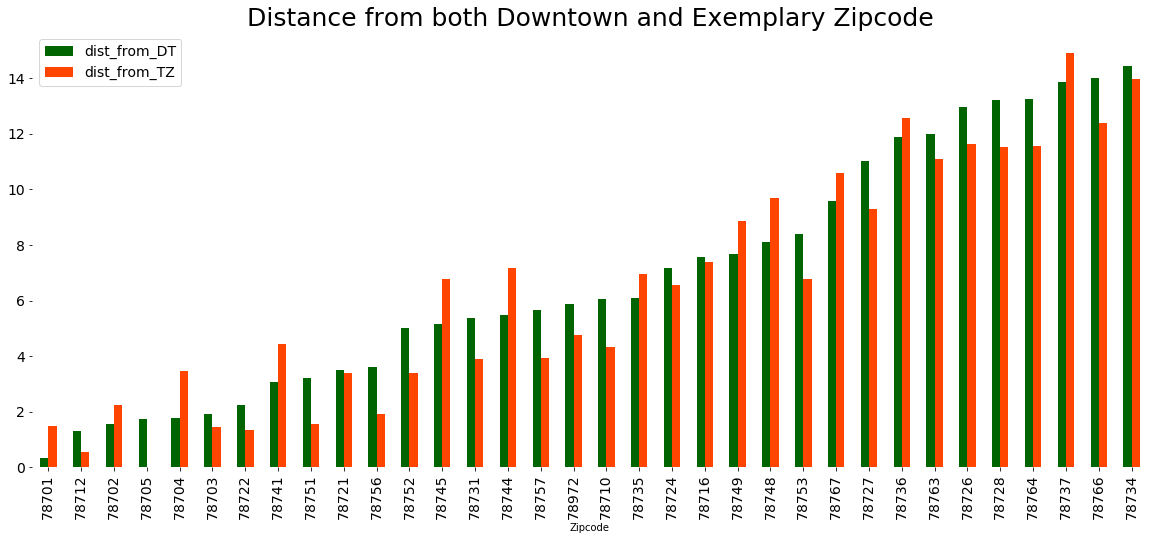

In [40]:
{
    "tags": [
        "hide_input",
    ]
}

ax=plot_data.plot(kind='bar', figsize=(20,8), fontsize=14, colors=['#006400', '#ff4500'])


ax.set_title('Distance from both Downtown and Exemplary Zipcode', fontsize=25)
ax.legend(fontsize=14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)


#### The ideal zipcode is less than 2 miles from the city center, but we will cast a slightly wider net and select locations that are within 3 miles of the city center

In [41]:
ideal_cluster_data=ideal_cluster_data[ideal_cluster_data['dist_from_DT'] < 3].reset_index(drop=True)
ideal_cluster_data

index  Zipcode   latitude  longitude  dist_from_DT  dist_from_TZ
0      9    78712  30.285207 -97.735394      1.307663      0.531941
1     10    78705  30.292424 -97.738560      1.719206      0.000000
2     11    78701  30.271270 -97.741030      0.314543      1.464624
3     13    78704  30.246309 -97.760870      1.780755      3.445273
4     16    78722  30.289307 -97.716590      2.231716      1.330762
5     17    78703  30.290907 -97.762770      1.907086      1.450986
6     30    78702  30.265158 -97.718790      1.565828      2.219138

#### Eliminate areas that are too close to the ideal zipcode and be left with our chosen candidate areas

In [42]:
candidate_areas=ideal_cluster_data[ideal_cluster_data['dist_from_TZ'] > 1.5].reset_index(drop=True)
candidate_areas

index  Zipcode   latitude  longitude  dist_from_DT  dist_from_TZ
0     13    78704  30.246309  -97.76087      1.780755      3.445273
1     30    78702  30.265158  -97.71879      1.565828      2.219138

## Results <a name="results"></a>

The analysis of Austin Texas segmented by zipcodes showed that the city is as of now under-served, with only **13** hookah bars in a city that large with a young population and an economy which is set to keep growing as the city expands its tech and other sectors.

After segmenting the city by zipcodes, the analysis here looked into which part of the city had been previously successful in the hookah business. This was done by using a **FourSquare API** query to get a listing of all hookah bars in the city. The resulting data was then tabulated and sorted & grouped by zipcode to find that in a city with **83** zipcodes and only **13** hookah bars, **4** of them were located in one particular zipcode (**78705**). This area is clearly ideal for that business, but is to be considered saturated. The savvy thing to do is therefore to extract the features of this area and see what other zones in the city are similar to it.

Another **FourSquare API** query was used to get a list of businesses in the zipcodes of the city and sort them by most popular for their region. A **k-means clustering** analysis was then performed to divide the regions into **8** clusters based on their **15** most popular venue categories. The cluster with the ideal characteristics was the one that contained our ideal zipcode and it was chosen for further analysis.

Many of the other zones in this cluster are too far from the city center to be considered safe for a new niche investment. We used the **geopy** distance module to append their distances from the city center onto the dataframe. We also obtained and appended their distance from the saturated/ideal region. Both of these values were used to find a balance between areas close to the city center, yet far away from competion.

The resulting two regions are zipcodes: **78702** and **78704**


## Conclusion <a name='conclusion'></a>

The aim of this project is to use available data and insights to help an entrepreneur select a region of Austin, Texas to establish a new hookah bar. We used sourced data from various sources and used several Python modules along with machine learning to extract hidden insights from the data.

The 2 candidate areas extracted from the data are the best places to explore locations for a new hookah bar. They are close to the center of the city central/business district. They are outside the single region which has a saturated amount of hookah bars, but are very similar to it in terms of what businesses tend to thrive in them. As such they are a mix of great opportunity and reduced competition. I have a high level of confidence that an entrepreneur who established a new venue in one these areas and followed other best practices of business would be very successful.